In [32]:
import cv2
import tkinter as tk
from tkinter import filedialog
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, IntSlider
import pydicom
from pydicom.dataset import FileDataset

from math import radians
from skimage.draw import line_nd

import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)

# DICOM file compatibility
from pydicom.dataset import Dataset, FileDataset
from pydicom.uid import ExplicitVRLittleEndian
import pydicom._storage_sopclass_uids
from skimage.util import img_as_ubyte
from skimage.exposure import rescale_intensity

Wybór startowych parametrów 

In [87]:

save_format=widgets.Dropdown(
    options=[('JPG',1),('DICOM',2)],
    value=1,
    description = "Saving format"
)
alpha_slider = IntSlider(min=1, max=4, step=1, value=2, description="Alpha")
detector_slider = IntSlider(min=90, max=720, step=90, value=360, description="Detectors")
display(save_format,alpha_slider,detector_slider)




Dropdown(description='Saving format', options=(('JPG', 1), ('DICOM', 2)), value=1)

IntSlider(value=2, description='Alpha', max=4, min=1)

IntSlider(value=360, description='Detectors', max=720, min=90, step=90)

2


In [34]:
print(save_format.value)
print(alpha_slider.value)

1


#### Wczytanie obrazu, przeskalowanie oraz nadanie mu paddingu

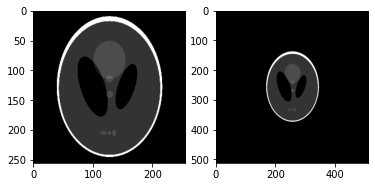

In [76]:
# Function to add padding to image

def add_padding(image, color=(0, 0, 0)):
    padding = int(image.shape[0]/2)
    padded_image = cv2.copyMakeBorder(image, padding, padding, padding, padding, cv2.BORDER_CONSTANT, value=color)
    return padded_image

def choose_file():
    root = tk.Tk()
    root.withdraw()
    root.call('wm', 'attributes', '.', '-topmost', True)
    filename = filedialog.askopenfilename(initialdir=".", title="Wybierz obraz", filetypes=(("jpeg files", ".jpg"), ("all files", ".")))
    %gui tk
    return filename

# Open file choose dialog
filename = choose_file()

# Read file and resize it to 256x256 pixels
img = cv2.imread(filename, 0)
img = cv2.resize(img, (256,256))

# Normalize image matrix to contain only values from range [0, 255]
img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
# Change coloring from BGR to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Change coloring from RGB to grayscale
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# Add padding to image for better results
padded_img = add_padding(img)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img, cmap="gray")
ax2.imshow(padded_img, cmap="gray")

#### Zapisywanie obrazu w formacie DICOM

Funkcja zapisująca plik w formacie DICOM wraz z danymi pacjenta oraz komentarzem do zdjęcia

In [77]:
def convert_image_to_ubyte(img):
    return img_as_ubyte(rescale_intensity(img, out_range=(0.0, 1.0)))

def save_as_dicom(file_name, img, patient_data):
    img_converted = convert_image_to_ubyte(img)
    
    # Populate required values for file meta information
    meta = Dataset()
    meta.MediaStorageSOPClassUID = pydicom._storage_sopclass_uids.CTImageStorage
    meta.MediaStorageSOPInstanceUID = pydicom.uid.generate_uid()
    meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian  

    ds = FileDataset(None, {}, preamble=b"\0" * 128)
    ds.file_meta = meta

    ds.is_little_endian = True
    ds.is_implicit_VR = False

    ds.SOPClassUID = pydicom._storage_sopclass_uids.CTImageStorage
    ds.SOPInstanceUID = meta.MediaStorageSOPInstanceUID
    
    ds.PatientName = patient_data["PatientName"]
    ds.PatientID = patient_data["PatientID"]
    ds.ImageComments = patient_data["ImageComments"]
    

    ds.Modality = "CT"
    ds.SeriesInstanceUID = pydicom.uid.generate_uid()
    ds.StudyInstanceUID = pydicom.uid.generate_uid()
    ds.FrameOfReferenceUID = pydicom.uid.generate_uid()

    ds.BitsStored = 8
    ds.BitsAllocated = 8
    ds.SamplesPerPixel = 1
    ds.HighBit = 7

    ds.ImagesInAcquisition = 1
    ds.InstanceNumber = 1

    ds.Rows, ds.Columns = img_converted.shape

    ds.ImageType = r"ORIGINAL\PRIMARY\AXIAL"

    ds.PhotometricInterpretation = "MONOCHROME2"
    ds.PixelRepresentation = 0

    pydicom.dataset.validate_file_meta(ds.file_meta, enforce_standard=True)

    ds.PixelData = img_converted.tobytes()

    ds.save_as(file_name, write_like_original=False)

Wybór zdjęcia i zapisanie go w formacie DICOM

In [78]:
# # Open file choose dialog
# filename = choose_file()

# # Read file and resize it to 256x256 pixels
# img = cv2.imread(filename, 0)
# img = cv2.resize(img, (256,256))
# img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

patient_data = {
    "PatientName" : "",
    "PatientID" : "",
    "ImageComments" : ""
}

# patient_data["PatientName"] = input("Podaj imię i nazwisko pacjenta: ")
# patient_data["PatientID"] = input("Podaj ID pacjenta: ")
# patient_data["ImageComments"] = input("Dodaj komentarz do zdjęcia: ")

# dicom_filename = filename.replace(".jpg", "") + ".dcm"

# save_as_dicom(dicom_filename, img, patient_data)

#### Odczyt plików DICOM

Imię i nazwisko:  Marek Kucmerka
ID pacjenta:  123456
Komentarz:  Ziomek jest zdrowy jak ko?


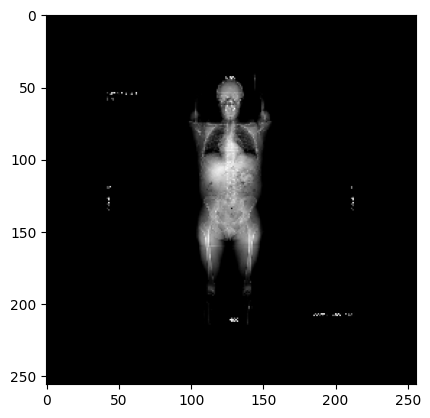

In [15]:
def choose_dicom_file():
    root = tk.Tk()
    root.withdraw()
    root.call('wm', 'attributes', '.', '-topmost', True)
    filename = filedialog.askopenfilename(initialdir=".", title="Wybierz obraz w formacie DICOM", filetypes=(("dicom files", ".dcm"), ("all files", ".")))
    %gui tk
    return filename

def load_dicom(filename):
    dicom_data = pydicom.dcmread(filename)
    image = dicom_data.pixel_array
    return dicom_data, image

filename = choose_dicom_file()

data, dicom_img = load_dicom(filename)

plt.imshow(dicom_img, cmap="gray")
print("Imię i nazwisko: ", data.PatientName)
print("ID pacjenta: ", data.PatientID)
print("Komentarz: ", data.ImageComments)

##### Funkcja Bresenhama do rysowania lini pomiędzy dwoma punktami

In [79]:
def bresenham(x0, y0, x1, y1):
    if abs(y1 - y0) > abs(x1 - x0):
        swapped = True
        x0, y0, x1, y1 = y0, x0, y1, x1
    else:
        swapped = False
    m = (y1 - y0) / (x1 - x0) if x1 - x0 != 0 else 1
    q = y0 - m * x0
    if x0 < x1:
        xs = np.arange(np.floor(x0), np.ceil(x1) + 1, +1, dtype=int)
    else:
        xs = np.arange(np.ceil(x0), np.floor(x1) - 1, -1, dtype=int)
    ys = np.round(m * xs + q).astype(int)
    if swapped:
        xs, ys = ys, xs
    return np.array([xs, ys])

def radon_lines(emitter, detectors):
    return bresenham(emitter[0], emitter[1], detectors[0], detectors[1])

##### Funkcja do wyliczenia pozycji emitera i detektorów

In [80]:
def calculate_position(radius, angle, offset=0):
    angle_radians = np.radians(angle + offset)
    return int(radius * np.cos(angle_radians) + radius), int(radius * np.sin(angle_radians) + radius)

##### Transformata Radona do wyliczenia macierzy sinogramu

In [81]:
def radon_transform(image, radius, angle_range, alpha, number_of_detectors, num_of_scans=360):
    # Calculate the number of scans (alpha is the angle that emiter changes after each iteration)
    number_of_scans = int(num_of_scans / alpha)
    # Create an array for final sinogram image
    sinogram = np.zeros((number_of_scans, number_of_detectors))

    for i in range(number_of_scans):
        # Calculate the current angle at which the emitter is
        angle = alpha * i
        # Calculate the position of the emitter
        emitter_pos = calculate_position(radius, angle)
        
        # Calculate positions of emitters
        detectors_positions = []
        for j in range(number_of_detectors):
            # Formula from PDF file for calculating the offset of detector
            offset = 180 - angle_range/2 + j*(angle_range)/(number_of_detectors - 1)
            detectors_positions.append(calculate_position(radius, angle, offset))
        
        for j, detector_pos in enumerate(detectors_positions):
            line_sum = 0
            rows, cols = radon_lines(emitter_pos, detector_pos)
            for x, y in zip(rows, cols):
                line_sum += image[x-1][y-1]
            sinogram[i][j] = line_sum/len(rows)

    return sinogram

##### Funkcja do aktualizowania wykresu sinogramu

In [82]:
# number_of_detectors = padded_img.shape[0]
# emitter_change_angle = 1
radius = padded_img.shape[0]//2
angle_range = 270
# sino = radon_transform(padded_img, radius, angle_range, emitter_change_angle, number_of_detectors)

sinograms={}

def update_sinogram(num_of_scans):
    if num_of_scans not in sinograms.keys():
        sinogram = radon_transform(padded_img, radius, angle_range, alpha_slider.value, detector_slider.value,num_of_scans)
        sinograms[num_of_scans]=sinogram
   
    plt.imshow(sinograms[num_of_scans], cmap="gray")

##### Przedstawienie pojedynczego sinogramu

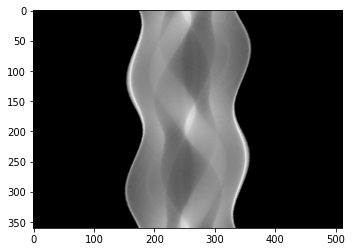

In [45]:
number_of_detectors = padded_img.shape[0]
emitter_change_angle = 1
radius = padded_img.shape[0]//2
angle_range = 270
sino = radon_transform(padded_img, radius, angle_range, emitter_change_angle, number_of_detectors)
plt.imshow(sino, cmap="gray")

##### Przedstawienie sinogramu wraz ze sliderami

In [46]:

scan_slider = IntSlider(min=90, max=360, step=90, value=360, description="Progress")

interact(update_sinogram, num_of_scans = scan_slider)

interactive(children=(IntSlider(value=2, description='Alpha', max=4, min=1), IntSlider(value=360, description=…

<function __main__.update_sinogram(alpha, num_detectors, num_of_scans)>

##### Funkcja odwrotnej transformaty Radona do odtworzenia obrazu na podstawie sinogramu

In [47]:
def inverse_radon(sinogram, radius, angle_range, alpha, detectors,num_of_scans=360):
    width = height = 2 * radius
    image = np.zeros((width, height))
    #num_of_scans = sinogram.shape[0]

    for i in range(num_of_scans):  # Iterate over angles
        angle = alpha * i
        emitter_pos = calculate_position(radius, angle)

        for j in range(detectors):  # Iterate over detectors
            detector_pos = calculate_position(radius, angle, np.degrees(np.pi - np.radians(angle_range) / 2 + j * (np.radians(angle_range) / (detectors - 1))))
            line = bresenham(emitter_pos[0], emitter_pos[1], detector_pos[0], detector_pos[1])

            for x, y in zip(line[0], line[1]):  # Iterate over line points
                image[x-1, y-1] += sinogram[i, j]

    image /= np.pi / sinogram.shape[0]  # Normalize by dividing by the angle step size

    return image

In [71]:
images={}
rec_image=inverse_radon(sino, radius, angle_range, emitter_change_angle, number_of_detectors)
def update_reconstructed(num_of_scans):
    if num_of_scans not in images.keys():
        reconstructed_image = inverse_radon(sino, radius, angle_range, emitter_change_angle, number_of_detectors,num_of_scans)
        images[num_of_scans]=reconstructed_image
    plt.imshow(images[num_of_scans], cmap="gray")


In [83]:

# print(save_format.value)
scans_slider = IntSlider(min=90, max=360, step=90, value=360, description="Progress")
interact(update_reconstructed, num_of_scans=scans_slider)
if save_format.value == 1:
    rec_image=cv2.normalize(rec_image, None, 0, 255, cv2.NORM_MINMAX)
    cv2.imwrite(filename.replace(".jpg","_scanned.jpg"),rec_image )

else:
    patient_data["PatientName"] = input("Podaj imię i nazwisko pacjenta: ")
    patient_data["PatientID"] = input("Podaj ID pacjenta: ")
    patient_data["ImageComments"] = input("Dodaj komentarz do zdjęcia: ")
    dicom_filename = filename.replace(".jpg", "") + ".dcm"
    save_as_dicom(dicom_filename, rec_image, patient_data)



interactive(children=(IntSlider(value=360, description='Progress', max=360, min=90, step=90), Output()), _dom_…